In [1]:
import numpy as np

rng = np.random.default_rng(0)

In [24]:
import numpy as np

def logp(x):
    return -0.5 * np.dot(x, x)

def grad_logp(x):
    return -x

def logp_new(x):
    mu1 = -2 * np.ones_like(x)
    mu2 = 2 * np.ones_like(x)
    term1 = np.exp(-0.5 * np.sum((x - mu1)**2))
    term2 = np.exp(-0.5 * np.sum((x - mu2)**2))
    return np.log(0.5 * term1 + 0.5 * term2)

def grad_logp_new(x):
    mu1 = -2 * np.ones_like(x)
    mu2 = 2 * np.ones_like(x)
    term1_val = np.exp(-0.5 * np.sum((x - mu1)**2))
    term2_val = np.exp(-0.5 * np.sum((x - mu2)**2))

    numerator = term1_val * (-(x - mu1)) + term2_val * (-(x - mu2))
    denominator = term1_val + term2_val
    return numerator / denominator

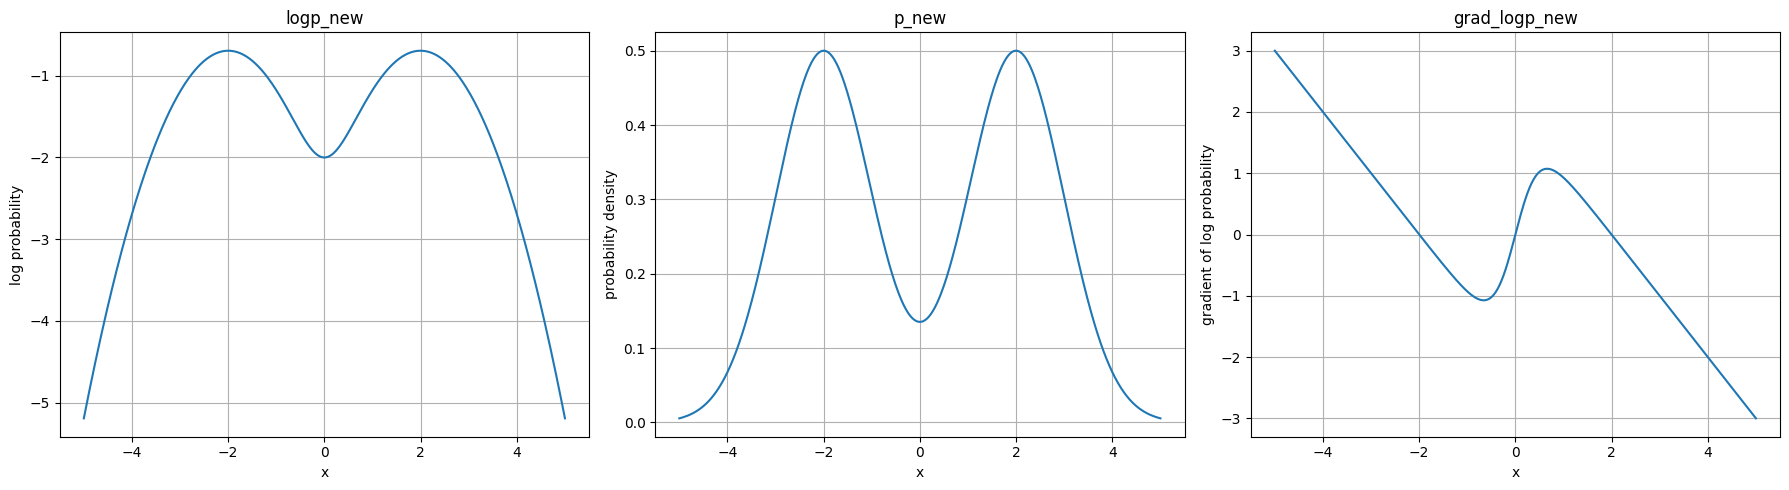

In [25]:
import matplotlib.pyplot as plt

x_vals = np.linspace(-5, 5, 500).reshape(-1, 1)
logp_vals = np.array([logp_new(x_val) for x_val in x_vals])
grad_logp_vals = np.array([grad_logp_new(x_val) for x_val in x_vals])
p_vals = np.exp(logp_vals)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(x_vals, logp_vals)
plt.title('logp_new')
plt.xlabel('x')
plt.ylabel('log probability')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(x_vals, p_vals)
plt.title('p_new')
plt.xlabel('x')
plt.ylabel('probability density')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(x_vals, grad_logp_vals)
plt.title('grad_logp_new')
plt.xlabel('x')
plt.ylabel('gradient of log probability')
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
''' Посчитаем ESS через интегрированную автокорреляции '''

def ess(x):
    x = x - x.mean()

    acf = np.correlate(x, x, mode='full')
    acf = acf[len(acf) // 2:]
    acf /= acf[0]

    tau = 1 + 2 * np.sum(acf[1:200])

    return len(x) / tau

In [18]:
''' Базовая реализация MH алгоритма '''

def mh(x0, steps, scale):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        prop = x + rng.normal(0, scale, size=d)

        if np.log(rng.uniform()) < (logp(prop) - logp(x)):
            x = prop; accept += 1

        chain[t] = x

    return chain, accept / steps

In [20]:
# Тут нужно заимплементить Metropolis Adjusted Langevin Algorithm (MALA)

def mala(x0, steps, step):
    x = x0.copy()
    d = len(x)

    chain = np.zeros((steps, d))
    accept = 0

    for t in range(steps):
        grad_x = grad_logp(x)
        prop_mean = x + (step / 2) * grad_x
        prop = prop_mean + np.sqrt(step) * rng.normal(0, 1, size=d)

        log_prob_prop = logp(prop)
        log_prob_x = logp(x)

        grad_prop = grad_logp(prop)

        term_q_x_given_prop = -0.5 / step * np.sum((x - (prop + (step / 2) * grad_prop))**2)

        term_q_prop_given_x = -0.5 / step * np.sum((prop - (x + (step / 2) * grad_x))**2)

        alpha = log_prob_prop - log_prob_x + term_q_x_given_prop - term_q_prop_given_x

        if np.log(rng.uniform()) < alpha:
            x = prop
            accept += 1

        chain[t] = x

    return chain, accept / steps

In [42]:
d = 10
steps = 30000
burn = 5000
x0 = np.ones(d) * 3 # стартанев в точке 3 например

mala_step = 1.295 # Подбирал для AR ~0.574
mh_scale = 0.798 # Подбирал для AR ~0.2314

print("--- Обычная гауссианка ---")

mh_chain_simple, mh_acc_simple = mh(x0, steps, scale=mh_scale)
mala_chain_simple, mala_acc_simple = mala(x0, steps, step=mala_step)

mh_ess_vals_simple = []
for i in range(d):
    mh_ess_vals_simple.append(ess(mh_chain_simple[burn:, i]))
median_mh_ess_simple = np.median(mh_ess_vals_simple)

mala_ess_vals_simple = []
for i in range(d):
    mala_ess_vals_simple.append(ess(mala_chain_simple[burn:, i]))
median_mala_ess_simple = np.median(mala_ess_vals_simple)

print(f"MH Acceptance Rate: {mh_acc_simple:.4f}")
print(f"MALA Acceptance Rate: {mala_acc_simple:.4f}")
print(f"Median ESS for MH (after burn-in): {median_mh_ess_simple:.2f}")
print(f"Median ESS for MALA (after burn-in): {median_mala_ess_simple:.2f}")

print("\n--- Двойная гауссианка  ---")

logp = logp_new
grad_logp = grad_logp_new

mh_chain_bimodal, mh_acc_bimodal = mh(x0, steps, scale=mh_scale)
mala_chain_bimodal, mala_acc_bimodal = mala(x0, steps, step=mala_step)

mh_ess_vals_bimodal = []
for i in range(d):
    mh_ess_vals_bimodal.append(ess(mh_chain_bimodal[burn:, i]))
median_mh_ess_bimodal = np.median(mh_ess_vals_bimodal)

mala_ess_vals_bimodal = []
for i in range(d):
    mala_ess_vals_bimodal.append(ess(mala_chain_bimodal[burn:, i]))
median_mala_ess_bimodal = np.median(mala_ess_vals_bimodal)

print(f"MH Acceptance Rate: {mh_acc_bimodal:.4f}")
print(f"MALA Acceptance Rate: {mala_acc_bimodal:.4f}")
print(f"Median ESS for MH (after burn-in): {median_mh_ess_bimodal:.2f}")
print(f"Median ESS for MALA (after burn-in): {median_mala_ess_bimodal:.2f}")

--- Обычная гауссианка ---
MH Acceptance Rate: 0.2348
MALA Acceptance Rate: 0.5779
Median ESS for MH (after burn-in): 852.81
Median ESS for MALA (after burn-in): 6884.59

--- Двойная гауссианка  ---
MH Acceptance Rate: 0.2378
MALA Acceptance Rate: 0.5748
Median ESS for MH (after burn-in): 786.61
Median ESS for MALA (after burn-in): 6785.42


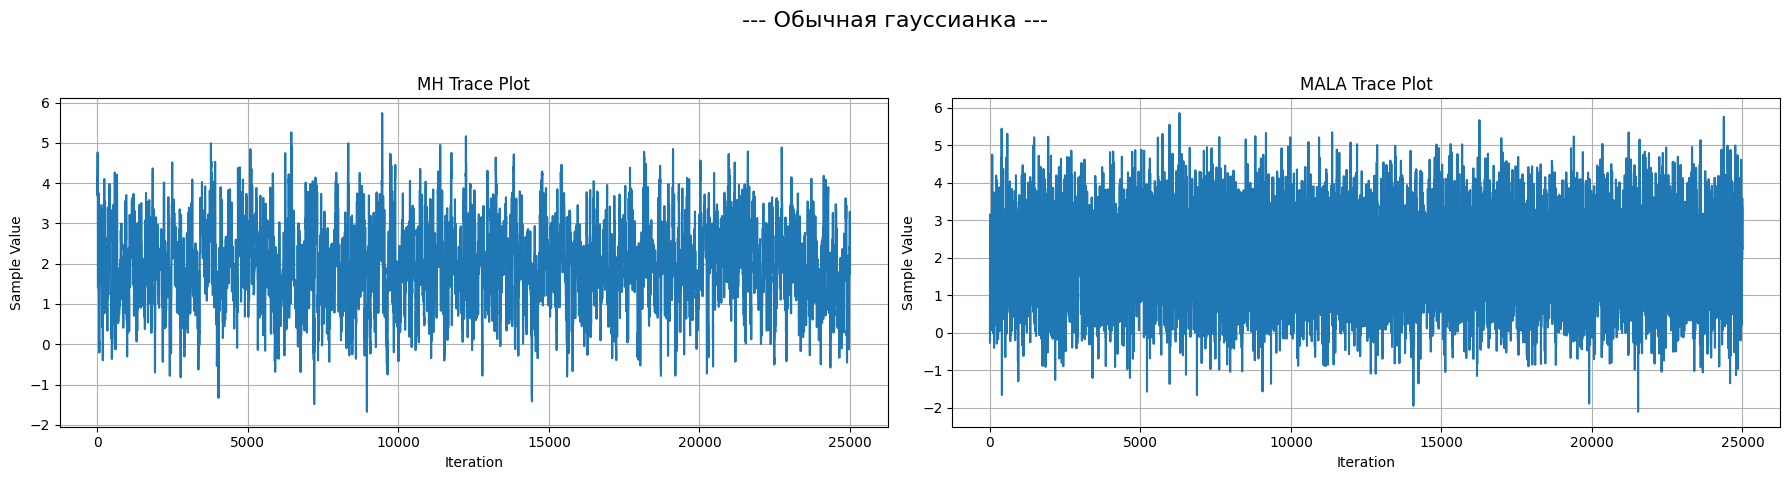

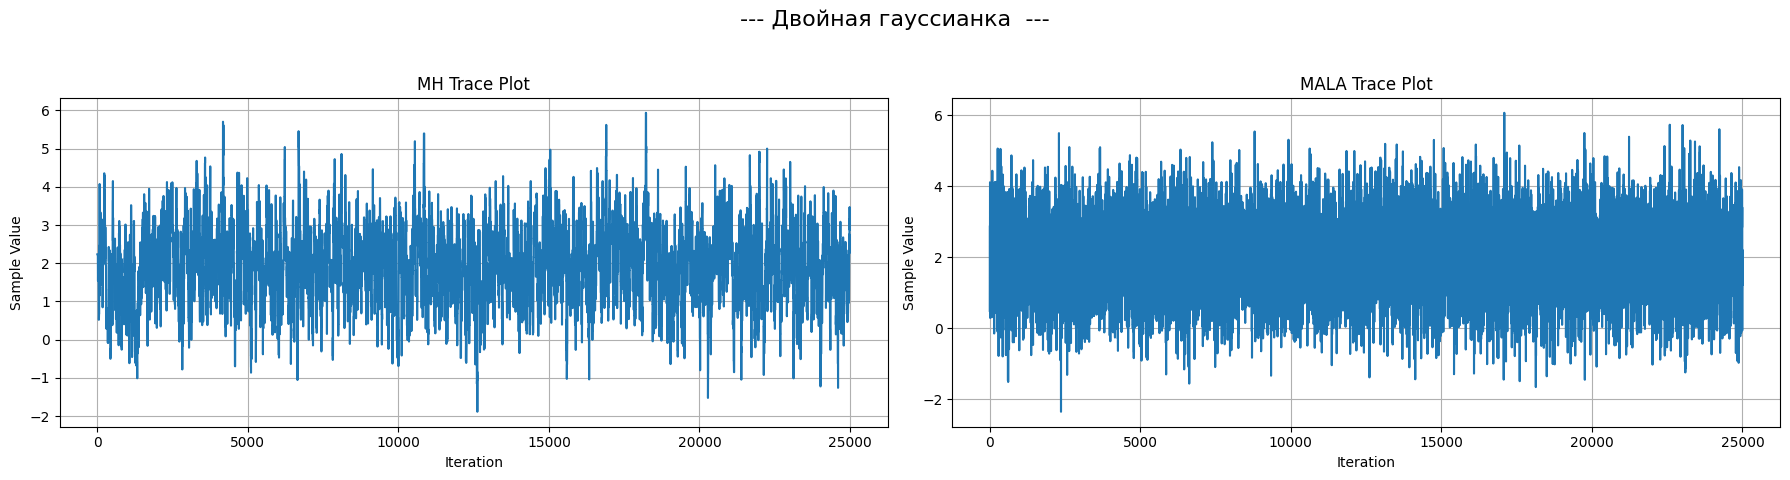

In [49]:
import matplotlib.pyplot as plt


plt.figure(figsize=(18, 5))
plt.suptitle('--- Обычная гауссианка ---', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(mh_chain_simple[burn:, 0])
plt.title('MH Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mala_chain_simple[burn:, 0])
plt.title('MALA Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(18, 5))
plt.suptitle('--- Двойная гауссианка  ---', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(mh_chain_bimodal[burn:, 0])
plt.title('MH Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mala_chain_bimodal[burn:, 0])
plt.title('MALA Trace Plot')
plt.xlabel('Iteration')
plt.ylabel('Sample Value')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

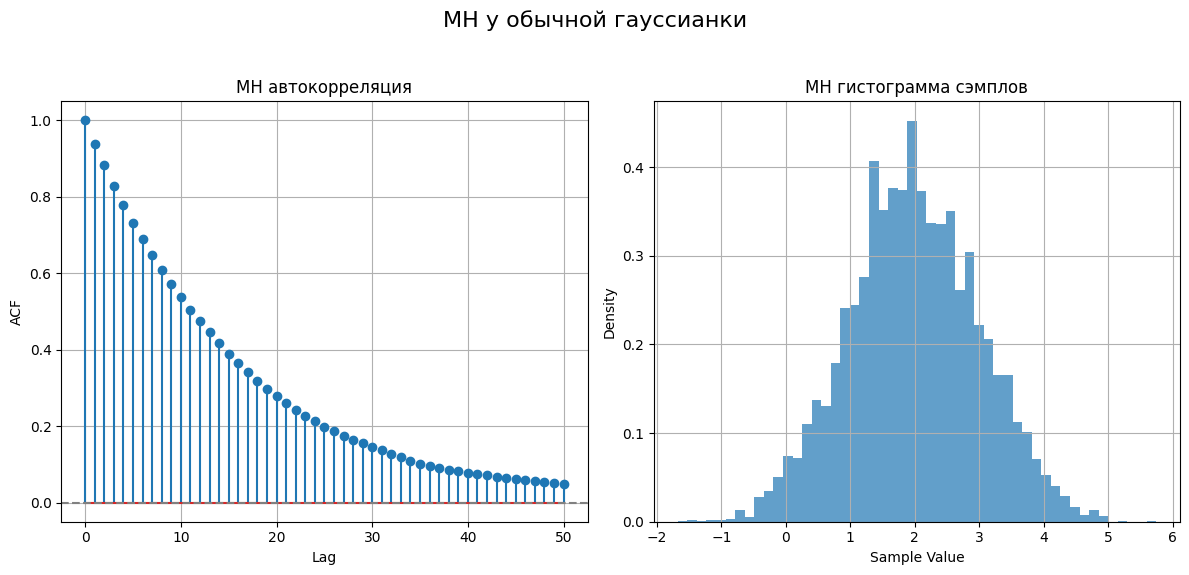

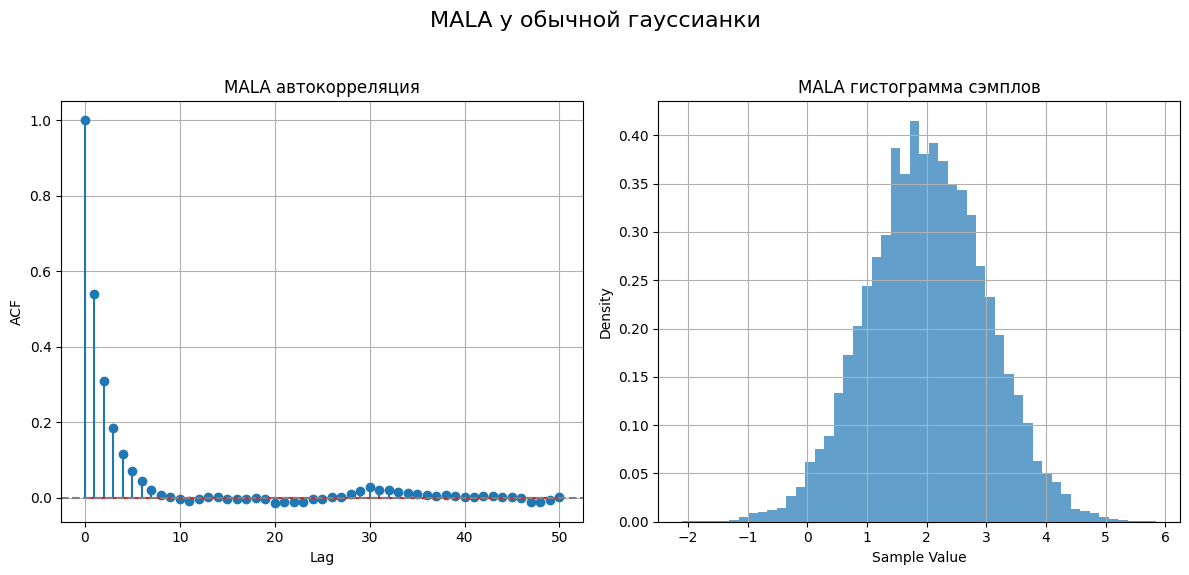

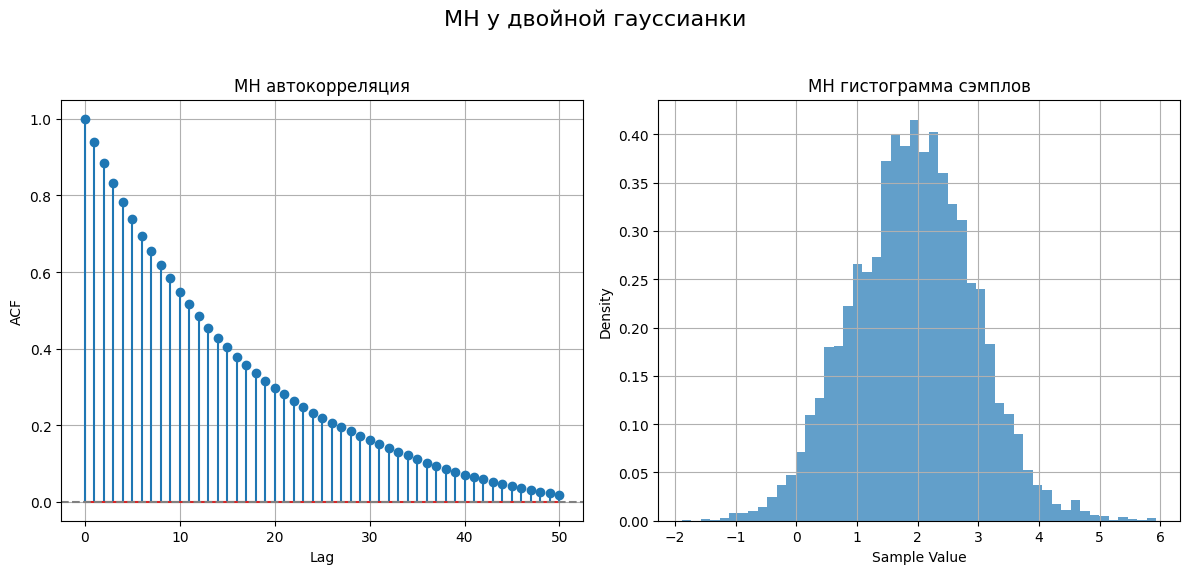

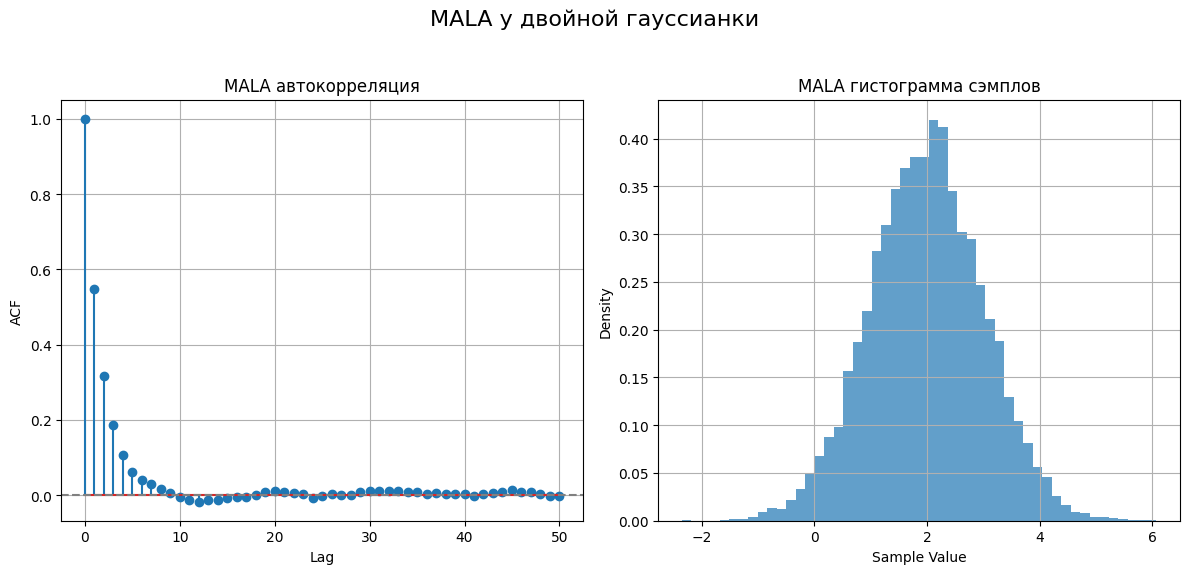

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_custom_acf(data, lags, ax, title):
    data_centered = data - np.mean(data)

    acf = np.correlate(data_centered, data_centered, mode='full')
    acf = acf[len(acf)//2:]
    acf = acf / acf[0]
    ax.stem(np.arange(lags + 1), acf[:lags + 1])
    ax.axhline(y=0, color='gray', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')
    ax.grid(True)


plt.figure(figsize=(12, 6))
plt.suptitle('MH у обычной гауссианки', fontsize=16)

plt.subplot(1, 2, 1)
plot_custom_acf(mh_chain_simple[burn:, 0], lags=50, ax=plt.gca(), title='MH автокорреляция')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(mh_chain_simple[burn:, 0], bins=50, density=True, alpha=0.7)
plt.title('MH гистограмма сэмплов')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6))
plt.suptitle('MALA у обычной гауссианки', fontsize=16)

plt.subplot(1, 2, 1)
plot_custom_acf(mala_chain_simple[burn:, 0], lags=50, ax=plt.gca(), title='MALA автокорреляция')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(mala_chain_simple[burn:, 0], bins=50, density=True, alpha=0.7)
plt.title('MALA гистограмма сэмплов')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6))
plt.suptitle('MH у двойной гауссианки', fontsize=16)

plt.subplot(1, 2, 1)
plot_custom_acf(mh_chain_bimodal[burn:, 0], lags=50, ax=plt.gca(), title='MH автокорреляция')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(mh_chain_bimodal[burn:, 0], bins=50, density=True, alpha=0.7)
plt.title('MH гистограмма сэмплов')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 6))
plt.suptitle('MALA у двойной гауссианки', fontsize=16)

plt.subplot(1, 2, 1)
plot_custom_acf(mala_chain_bimodal[burn:, 0], lags=50, ax=plt.gca(), title='MALA автокорреляция')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(mala_chain_bimodal[burn:, 0], bins=50, density=True, alpha=0.7)
plt.title('MALA гистограмма сэмплов')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Вывод: лучше MALA, так как у MALA лучше перемешивается трейс плот, больше ESS, автокорреляция затухает быстрее. Мб если чутка поднастроить, то и MH будет выдавать лучше результаты, здесь я шаг подобрал под AR 23.14%, что по идее считается оптимальным, но возможно если подбирать под оптимальный трейс плот, то выйдет лучше. Однако всё равно MALA показывает качественно лучший результат